[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]
(https://colab.research.google.com/github/mae576-gdl/gdl-course-materials/blob/main/lectures/lecture01/lecture01_why_structure_matters.ipynb)

> ⚠️ Changes made in Colab are temporary.  
> To keep your work, use **File → Save a copy in Drive**.


# GDL Lecture 1 — Why Structure Matters

This notebook supports the live demos from Lecture 1.

**We will**:

1. See what data augmentation can (and cannot) do for an MLP on images.
2. See what happens when we change to a model that explicitly encodes spatial locality.

The point is not “MLPs are bad.” The point is: **generalization depends on assumptions** (inductive bias), and **structure is one of the strongest sources of bias**.

In [1]:
import os
import math
import random
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Note: deterministic mode can slow GPU a bit; keep it simple for class.
set_seed(0)


torch: 2.5.1
cuda available: False


# A tiny MLP

We’ll use a simple MLP: flatten 28×28 → hidden layers → 10 logits.

This is intentionally structure-ignorant: it does **not** know what “neighboring pixels” means.

In [2]:
class MLP(nn.Module):
    def __init__(self, hidden=256, depth=2, dropout=0.0):
        super().__init__()
        layers = []
        in_dim = 28 * 28
        for _ in range(depth):
            layers.append(nn.Linear(in_dim, hidden))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = hidden
        layers.append(nn.Linear(in_dim, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

@torch.no_grad()
def accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

def train_epoch(model, loader, opt):
    model.train()
    total_loss = 0.0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * y.size(0)
        total += y.size(0)
    return total_loss / total

def run_training(model, train_loader, test_loader, epochs=3, lr=1e-3):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = {"train_loss": [], "test_acc": []}
    for ep in range(1, epochs+1):
        tr_loss = train_epoch(model, train_loader, opt)
        te_acc = accuracy(model, test_loader)
        hist["train_loss"].append(tr_loss)
        hist["test_acc"].append(te_acc)
        print(f"epoch {ep:02d} | train loss {tr_loss:.4f} | test acc {te_acc*100:.2f}%")
    return hist


# Data loaders

We’ll create loaders for:

* baseline MNIST (no translation)
* augmented MNIST (random translations during training)
* shifted MNIST test (a distribution shift: fixed translation at test time)

In [3]:
@dataclass
class Config:
    batch_size: int = 256
    num_workers: int = 2
    data_dir: str = "./data"
    epochs_quick: int = 3
    epochs_long: int = 8

cfg = Config()

# Baseline transform
tf_base = T.ToTensor()

# Augmentation: small translations (pad then random crop)
# This is the standard, stable way to simulate translation.
tf_aug = T.Compose([
    T.Pad(4),
    T.RandomCrop(28),
    T.ToTensor()
])

# "Shifted" test set: deterministic shift (pad then crop off-center)
# We'll implement a deterministic translation by using a fixed crop.
# For example: shift right/down by 4 pixels.
class FixedShift:
    def __init__(self, pad=4, shift_x=4, shift_y=4):
        self.pad = pad
        self.shift_x = shift_x
        self.shift_y = shift_y
    def __call__(self, img):
        img = T.functional.pad(img, padding=self.pad, fill=0)
        # Crop a 28x28 window starting at (shift_y, shift_x)
        img = T.functional.crop(img, top=self.shift_y, left=self.shift_x, height=28, width=28)
        return img

tf_shift_test = T.Compose([
    FixedShift(pad=1, shift_x=4, shift_y=4),
    T.ToTensor()
])

train_base = torchvision.datasets.MNIST(cfg.data_dir, train=True, download=True, transform=tf_base)
train_aug  = torchvision.datasets.MNIST(cfg.data_dir, train=True, download=True, transform=tf_aug)

test_base  = torchvision.datasets.MNIST(cfg.data_dir, train=False, download=True, transform=tf_base)
test_shift = torchvision.datasets.MNIST(cfg.data_dir, train=False, download=True, transform=tf_shift_test)

train_loader_base = DataLoader(train_base, batch_size=cfg.batch_size, shuffle=True,
                               num_workers=cfg.num_workers, pin_memory=True)
train_loader_aug = DataLoader(train_aug, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)

test_loader_base = DataLoader(test_base, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
test_loader_shift = DataLoader(test_shift, batch_size=cfg.batch_size, shuffle=False,
                               num_workers=cfg.num_workers, pin_memory=True)


# Sanity check: visualize the transforms

Before training anything, let’s look at baseline vs augmented vs shifted images.

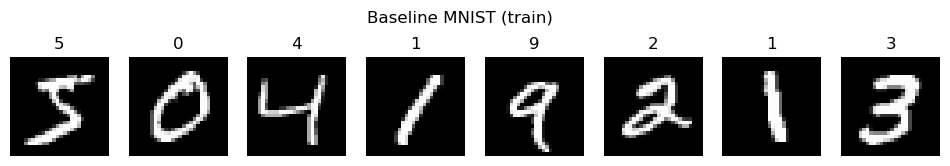

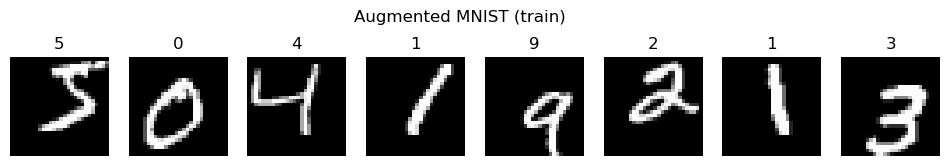

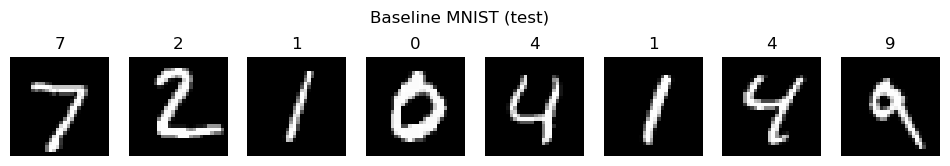

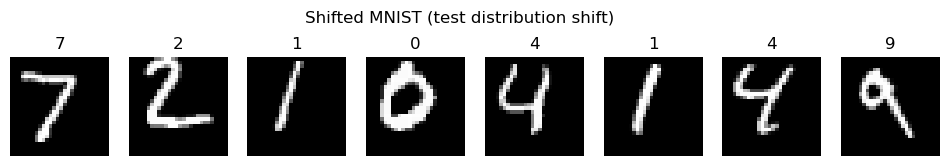

In [4]:
def show_examples(ds, title, n=8):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        x, y = ds[i]
        plt.subplot(1, n, i+1)
        plt.imshow(x.squeeze(0), cmap="gray")
        plt.axis("off")
        plt.title(str(y))
    plt.suptitle(title)
    plt.show()

show_examples(train_base, "Baseline MNIST (train)")
show_examples(train_aug,  "Augmented MNIST (train)")
show_examples(test_base, "Baseline MNIST (test)")
show_examples(test_shift, "Shifted MNIST (test distribution shift)")


# Demo 1 — Data augmentation: what it does and doesn’t do

## The question

Question: If we train an MLP with random translations, do we get “translation invariance”?

We’ll compare:

1. Train baseline → test baseline and test shifted
2. Train augmented → test baseline and test shifted

The core point: augmentation adds samples, but does not force equivalence.

In [5]:
set_seed(0)
mlp_base = MLP(hidden=256, depth=2, dropout=0.0)
hist_base = run_training(
    mlp_base,
    train_loader_base,
    test_loader_base,
    epochs=cfg.epochs_quick,
    lr=1e-3
)

acc_base_on_base = accuracy(mlp_base, test_loader_base)
acc_base_on_shift = accuracy(mlp_base, test_loader_shift)

print(f"Baseline-trained MLP | test(base):  {acc_base_on_base*100:.2f}%")
print(f"Baseline-trained MLP | test(shift): {acc_base_on_shift*100:.2f}%")


epoch 01 | train loss 0.4171 | test acc 94.52%
epoch 02 | train loss 0.1598 | test acc 96.20%
epoch 03 | train loss 0.1053 | test acc 96.93%
Baseline-trained MLP | test(base):  96.93%
Baseline-trained MLP | test(shift): 17.00%


In [6]:
set_seed(0)
mlp_aug = MLP(hidden=256, depth=2, dropout=0.0)
hist_aug = run_training(
    mlp_aug,
    train_loader_aug,
    test_loader_base,
    epochs=cfg.epochs_quick,
    lr=1e-3
)

acc_aug_on_base = accuracy(mlp_aug, test_loader_base)
acc_aug_on_shift = accuracy(mlp_aug, test_loader_shift)

print(f"Aug-trained MLP | test(base):  {acc_aug_on_base*100:.2f}%")
print(f"Aug-trained MLP | test(shift): {acc_aug_on_shift*100:.2f}%")


epoch 01 | train loss 0.8737 | test acc 90.46%
epoch 02 | train loss 0.3119 | test acc 94.04%
epoch 03 | train loss 0.2377 | test acc 94.17%
Aug-trained MLP | test(base):  94.17%
Aug-trained MLP | test(shift): 93.25%


## Discuss

* Augmentation usually improves performance on shifted test data.
* But the network is still not invariant in a principled sense.

**Key distinction**:
Augmentation expands the training set.
It does not restrict the function class.

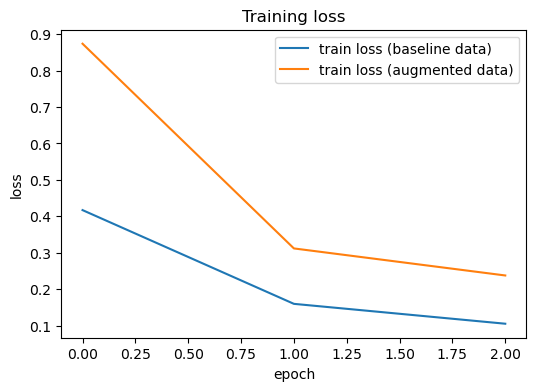

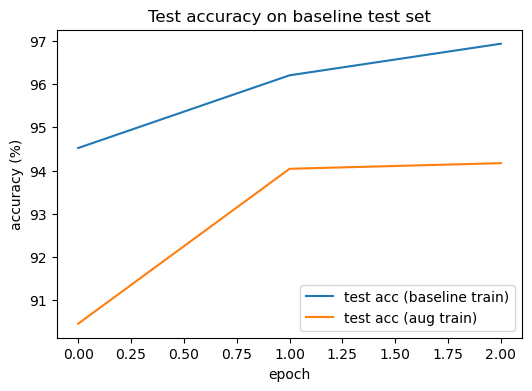

In [7]:
plt.figure(figsize=(6,4))
plt.plot(hist_base["train_loss"], label="train loss (baseline data)")
plt.plot(hist_aug["train_loss"], label="train loss (augmented data)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Training loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot([100*a for a in hist_base["test_acc"]], label="test acc (baseline train)")
plt.plot([100*a for a in hist_aug["test_acc"]], label="test acc (aug train)")
plt.xlabel("epoch")
plt.ylabel("accuracy (%)")
plt.legend()
plt.title("Test accuracy on baseline test set")
plt.show()


# Demo 2 — Same data, different model: MLP vs CNN

Now we hold the data fixed and change the architecture.

**Question**: Which model generalizes better to translated digits — and why?

We’ll compare:

* MLP (no built-in locality / parameter sharing)
* CNN (built-in locality + translation-friendly parameter sharing)

In [8]:
class SmallCNN(nn.Module):
    def __init__(self, channels=32, hidden=128, dropout=0.0):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(channels, 2*channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear((2*channels) * 7 * 7, hidden),
            nn.ReLU(),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


We’ll always report two accuracies:
* test on the standard MNIST test set
* test on the shifted (translated) test set

The **gap** is the important thing.

In [9]:
@torch.no_grad()
def acc_on_both(model, test_loader_base, test_loader_shift):
    a0 = accuracy(model, test_loader_base)
    a1 = accuracy(model, test_loader_shift)
    return a0, a1


# Train on centered MNIST (no augmentation)

This is the cleanest apples-to-apples test: same data, different model.

In [10]:
set_seed(0)
mlp = MLP(hidden=256, depth=2, dropout=0.0).to(device)

print("Training MLP on baseline data...")
hist_mlp_base = run_training(mlp, train_loader_base, test_loader_base, epochs=cfg.epochs_quick, lr=1e-3)

mlp_base_acc, mlp_shift_acc = acc_on_both(mlp, test_loader_base, test_loader_shift)
print(f"MLP | test(base):  {mlp_base_acc*100:.2f}%")
print(f"MLP | test(shift): {mlp_shift_acc*100:.2f}%")


Training MLP on baseline data...
epoch 01 | train loss 0.4171 | test acc 94.52%
epoch 02 | train loss 0.1598 | test acc 96.20%
epoch 03 | train loss 0.1053 | test acc 96.93%
MLP | test(base):  96.93%
MLP | test(shift): 17.00%


In [11]:
set_seed(0)
cnn = SmallCNN(channels=16, hidden=128, dropout=0.0).to(device)

print("Training CNN on baseline data...")
hist_cnn_base = run_training(cnn, train_loader_base, test_loader_base, epochs=cfg.epochs_quick, lr=1e-3)

cnn_base_acc, cnn_shift_acc = acc_on_both(cnn, test_loader_base, test_loader_shift)
print(f"CNN | test(base):  {cnn_base_acc*100:.2f}%")
print(f"CNN | test(shift): {cnn_shift_acc*100:.2f}%")


Training CNN on baseline data...
epoch 01 | train loss 0.4335 | test acc 96.58%
epoch 02 | train loss 0.0909 | test acc 97.73%
epoch 03 | train loss 0.0594 | test acc 98.38%
CNN | test(base):  98.38%
CNN | test(shift): 33.72%


In [12]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("MLP params:", count_params(mlp))
print("CNN params:", count_params(cnn))


MLP params: 269322
CNN params: 206922


## Discuss:
* Which model had the smaller base→shift drop?
* Why is that drop a measure of “respecting structure”?

**Key idea**: the CNN doesn’t “see more data.”
It searches a **smaller class of functions** via weight sharing + locality.

In [13]:
set_seed(0)
mlp_aug2 = MLP(hidden=256, depth=2, dropout=0.0).to(device)

print("Training MLP on augmented data...")
hist_mlp_aug = run_training(mlp_aug2, train_loader_aug, test_loader_base, epochs=cfg.epochs_quick, lr=1e-3)

mlp_aug_base_acc, mlp_aug_shift_acc = acc_on_both(mlp_aug2, test_loader_base, test_loader_shift)
print(f"MLP+aug | test(base):  {mlp_aug_base_acc*100:.2f}%")
print(f"MLP+aug | test(shift): {mlp_aug_shift_acc*100:.2f}%")
set_seed(0)
cnn_aug2 = SmallCNN(channels=32, hidden=128, dropout=0.0).to(device)

print("Training CNN on augmented data...")
hist_cnn_aug = run_training(cnn_aug2, train_loader_aug, test_loader_base, epochs=cfg.epochs_quick, lr=1e-3)

cnn_aug_base_acc, cnn_aug_shift_acc = acc_on_both(cnn_aug2, test_loader_base, test_loader_shift)
print(f"CNN+aug | test(base):  {cnn_aug_base_acc*100:.2f}%")
print(f"CNN+aug | test(shift): {cnn_aug_shift_acc*100:.2f}%")


Training MLP on augmented data...
epoch 01 | train loss 0.8737 | test acc 90.46%
epoch 02 | train loss 0.3119 | test acc 94.04%
epoch 03 | train loss 0.2377 | test acc 94.17%
MLP+aug | test(base):  94.17%
MLP+aug | test(shift): 93.25%
Training CNN on augmented data...
epoch 01 | train loss 0.6664 | test acc 95.86%
epoch 02 | train loss 0.1848 | test acc 97.10%
epoch 03 | train loss 0.1241 | test acc 98.03%
CNN+aug | test(base):  98.03%
CNN+aug | test(shift): 97.57%


In [41]:
set_seed(0)
cnn_aug2 = SmallCNN(channels=32, hidden=128, dropout=0.0).to(device)

print("Training CNN on augmented data...")
hist_cnn_aug = run_training(cnn_aug2, train_loader_aug, test_loader_base, epochs=cfg.epochs_quick, lr=1e-3)

cnn_aug_base_acc, cnn_aug_shift_acc = acc_on_both(cnn_aug2, test_loader_base, test_loader_shift)
print(f"CNN+aug | test(base):  {cnn_aug_base_acc*100:.2f}%")
print(f"CNN+aug | test(shift): {cnn_aug_shift_acc*100:.2f}%")


Training CNN on augmented data...
epoch 01 | train loss 0.6664 | test acc 95.86%
epoch 02 | train loss 0.1848 | test acc 97.10%
epoch 03 | train loss 0.1241 | test acc 98.03%
CNN+aug | test(base):  98.03%
CNN+aug | test(shift): 97.57%


The pattern you’re looking for is typically:

* CNN > MLP on shifted test (especially without augmentation)
* augmentation helps both
* CNN still tends to be more sample-efficient / stable under shift

In [42]:
def fmt(p): 
    return f"{p*100:6.2f}%"

summary = {
    "MLP (base train)":     (mlp_base_acc, mlp_shift_acc),
    "CNN (base train)":     (cnn_base_acc, cnn_shift_acc),
    "MLP (aug train)":      (mlp_aug_base_acc, mlp_aug_shift_acc),
    "CNN (aug train)":      (cnn_aug_base_acc, cnn_aug_shift_acc),
}

print(f"{'model':22s} | {'test(base)':>10s} | {'test(shift)':>10s} | {'drop':>8s}")
print("-"*60)
for k, (a0, a1) in summary.items():
    print(f"{k:22s} | {fmt(a0):>10s} | {fmt(a1):>10s} | {fmt(a0-a1):>8s}")


model                  | test(base) | test(shift) |     drop
------------------------------------------------------------
MLP (base train)       |     96.93% |     17.00% |   79.93%
CNN (base train)       |     98.38% |     33.72% |   64.66%
MLP (aug train)        |     94.17% |     93.25% |    0.92%
CNN (aug train)        |     98.03% |     97.57% |    0.46%


## Takeaways
1. Augmentation adds training examples; it does not directly constrain functions.
2. CNNs encode assumptions (locality + parameter sharing) that match image structure.
3. Those assumptions often improve generalization under shifts and data efficiency.

**Next lecture**: we’ll formalize what it means to “respect structure” (invariance/equivariance).